# Cardiovascular Disease Prediction

---



# made by :
#1- omar adel hazzaa
# 2- norsen ismail
# 3- Ann Michel Yacoub
# 4- Adham Desouky
# 5- Khadija Hossam El-din
# 6- Zeina Salah

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b7be430667e00d8bd8c306c072aa89fea2af884d81f58aa1f59d386bcc080af7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Spark Session and DataFrame Operations
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# For Visualization (limited compared to Matplotlib and Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries in PySpark
from pyspark.ml import Pipeline
from pyspark.ml.feature import (VectorAssembler, StringIndexer, OneHotEncoder,
                                StandardScaler, Imputer)
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier,
                                       RandomForestClassifier, GBTClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Imbalanced Data Handling (PySpark doesn't have built-in SMOTE, requires custom implementation or external library)
# from imblearn.over_sampling import SMOTE  # Not directly available in PySpark, would need separate handling

# Initialize Spark Session
spark = SparkSession.builder.appName("CardiovascularDiseasePrediction").getOrCreate()

# GridSearch and Cross-Validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



In [ ]:
def head(df, shape_only=False):
    print((df.count(), len(df.columns)))

    if shape_only:
        return
    else:
        return df.show(5)


# Exploratory Data Analysis (EDA)

2. EDA of Categorical Values

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda_bivariate_categorical(df, column, target):
    # Convert Spark DataFrame to Pandas DataFrame
    pdf = df.select(column, target).toPandas()

    fig, ax = plt.subplots(figsize=(9, 8))
    color = 'Set2'
    palette_color = sns.color_palette(color)
    ax = sns.countplot(x=column, data=pdf, hue=target, palette=color, order=pdf[column].value_counts().index)
    ax.set_ylabel('Count')
    offset = pdf[column].value_counts().max() * 0.005
    list_bars = pdf.groupby([column, target])[column].agg(['count']).unstack().fillna(0).values
    patches = ax.patches
    bars_pos = 0

    for i in range(pdf[target].nunique()):
        for j in range(pdf[column].nunique()):
            list_bars_col = list_bars[j]
            total_sum = list_bars_col.sum()
            value = list_bars_col[i]
            percentage = value / total_sum
            if percentage == 0:
                bars_pos += 1
                continue
            else:
                x = patches[bars_pos].get_x() + patches[j].get_width() / 2
                y = patches[bars_pos].get_height() + offset
                ax.annotate('{:.1f}%'.format(percentage * 100), (x, y), ha='center')
                bars_pos += 1
    plt.show()


3. Plotting Numerical Variables

In [ ]:
def eda_bivariate_numerical(df, column, target, color, figsize=(12, 6), val=0, target_type='Numerical'):
    # Convert Spark DataFrame to Pandas DataFrame
    pdf = df.select(column, target).toPandas()

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    cmap = sns.color_palette(color)
    val = val

    for i in range(1):
        for j in range(2):
            if j == 0:
                sns.histplot(data=pdf, x=column, hue=target, bins=50, kde=True, palette=color, ax=axes[j])
                axes[j].set(xlabel=None)
                axes[j].grid(False)
            elif j == 1:
                sns.boxplot(data=pdf, x=column, y=target, ax=axes[j], palette=color, orient='h')
                axes[j].set(xlabel=None)
                axes[j].grid(False)
                val += 1
                plt.tight_layout()
            if target_type == 'Numerical':
                plt.suptitle(column)
            else:
                plt.suptitle(f'{column} vs. {target}')
    plt.show()


4. Printing Text with a Specific Font

In [ ]:
def print_text(text):
    fig, ax = plt.subplots(figsize=(6, 1), facecolor="#eefade")
    ax.text(0.5, 0.5, text, ha='center', va='center', size=40)
    ax.axis("off")
    plt.show()


Loading the Data and Viewing the DataFrame

In [ ]:
# Load data into Spark DataFrame
df = spark.read.csv('/content/CVD_cleaned.csv', header=True, inferSchema=True)

# Viewing the DataFrame and shape
head(df, shape_only=False)


(9984, 19)
+--------------+--------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|General_Health|             Checkup|Exercise|Heart_Disease|Skin_Cancer|Other_Cancer|Depression|Diabetes|Arthritis|   Sex|Age_Category|Height_(cm)|Weight_(kg)|  BMI|Smoking_History|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|
+--------------+--------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|          Poor|Within the past 2...|      No|           No|         No|          No|        No|      No|      Yes|Female|       70-74|      150.0|      32.66|14.54|     

In [ ]:
# Setting the target variable
target = 'Heart_Disease'

# Creating numerical and categorical columns
numerical_cols = [col for col, dtype in df.dtypes if dtype != 'string']
categorical_cols = [col for col, dtype in df.dtypes if dtype == 'string']

# Sorting the columns
numerical_cols.sort()
categorical_cols.sort()

# Printing the length of numerical and categorical columns
print(f'There are {len(categorical_cols)} Categorical variables')
print(f'There are {len(numerical_cols)} Numerical variables')


There are 12 Categorical variables
There are 7 Numerical variables


# Target Variable¶

# Categorical

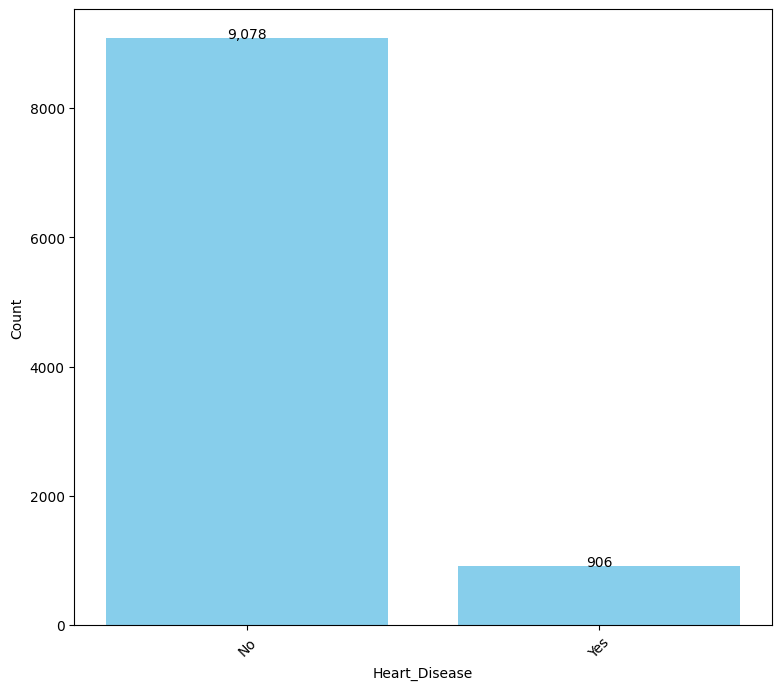

In [ ]:
import matplotlib.pyplot as plt

# Calculate count of each category of the target variable
target_counts = df.groupBy(target).count().orderBy(target).toPandas()

# Plot the countplot
plt.figure(figsize=(9, 8))
plt.bar(target_counts[target], target_counts['count'], color='skyblue')

# Add count labels on top of the bars
for i, count in enumerate(target_counts['count']):
    plt.text(i, count + 0.5, f'{count:,}', ha='center')

plt.xlabel(target)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Univariate Analysis

General_Health


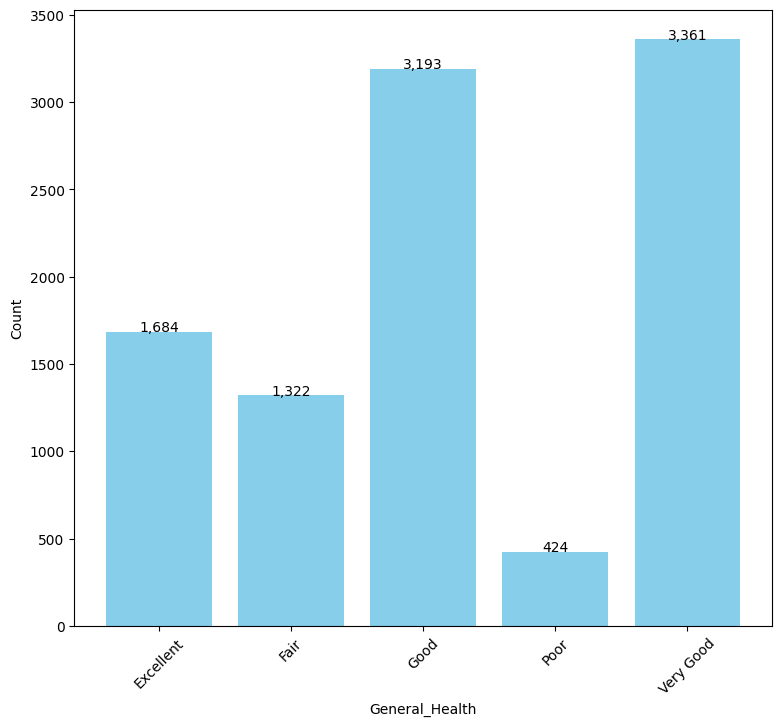

Checkup


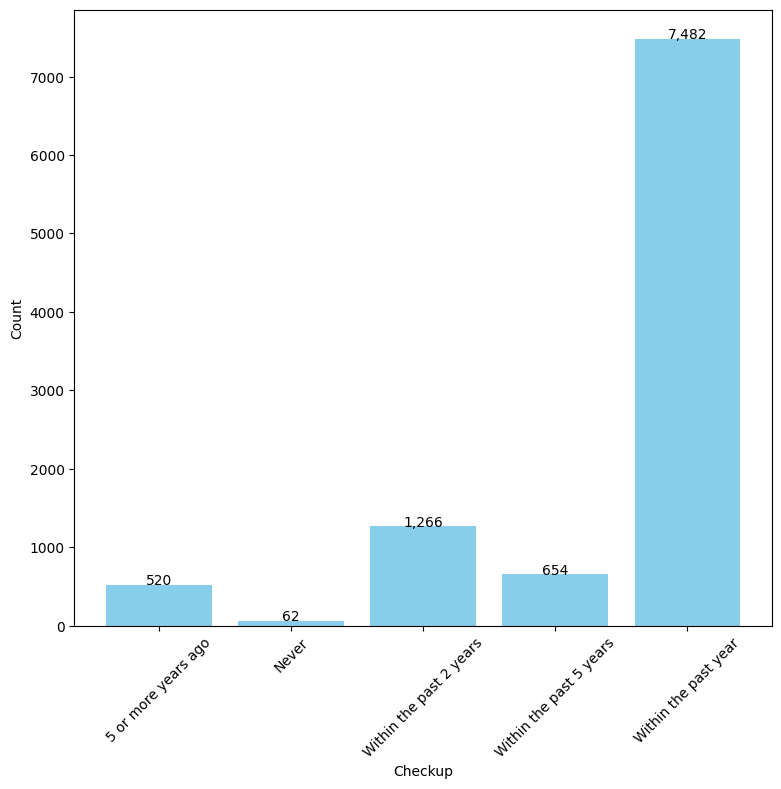

Exercise


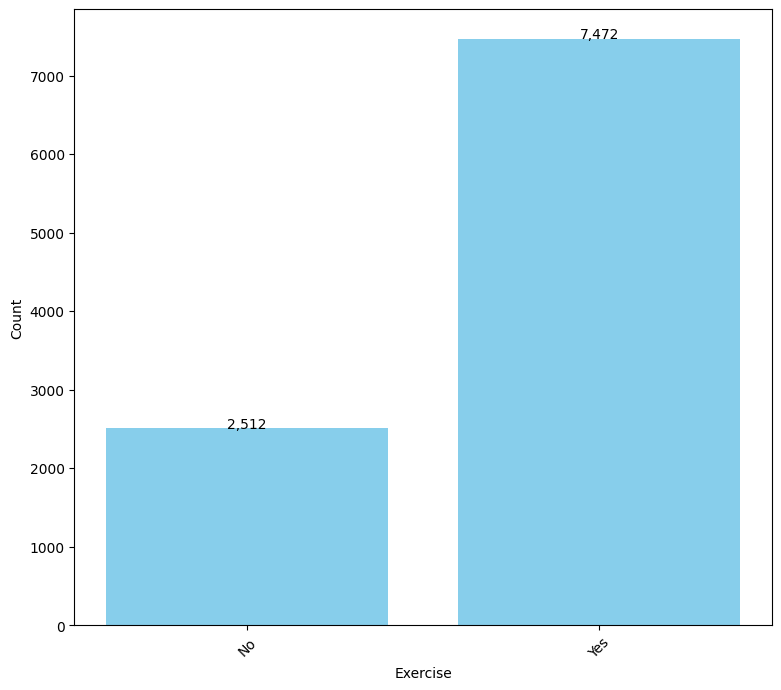

Skin_Cancer


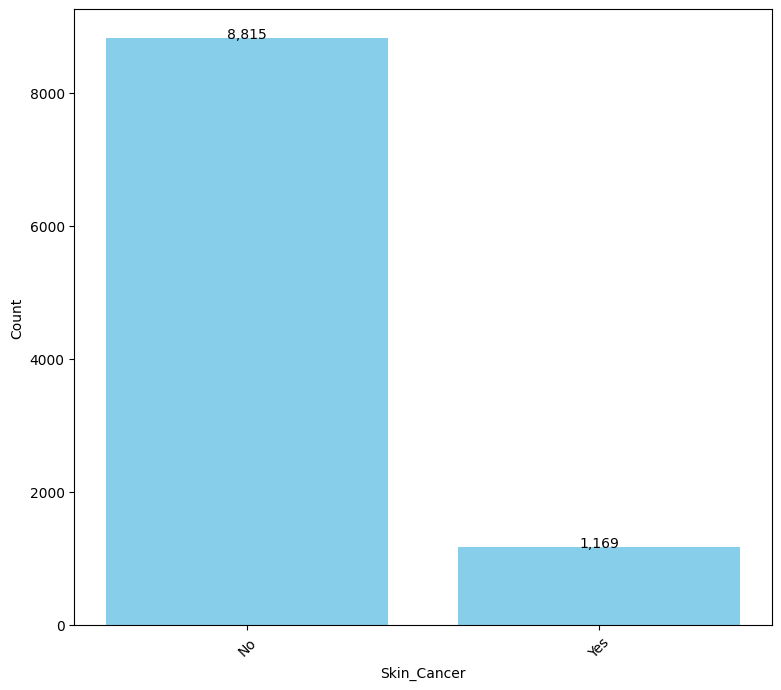

Other_Cancer


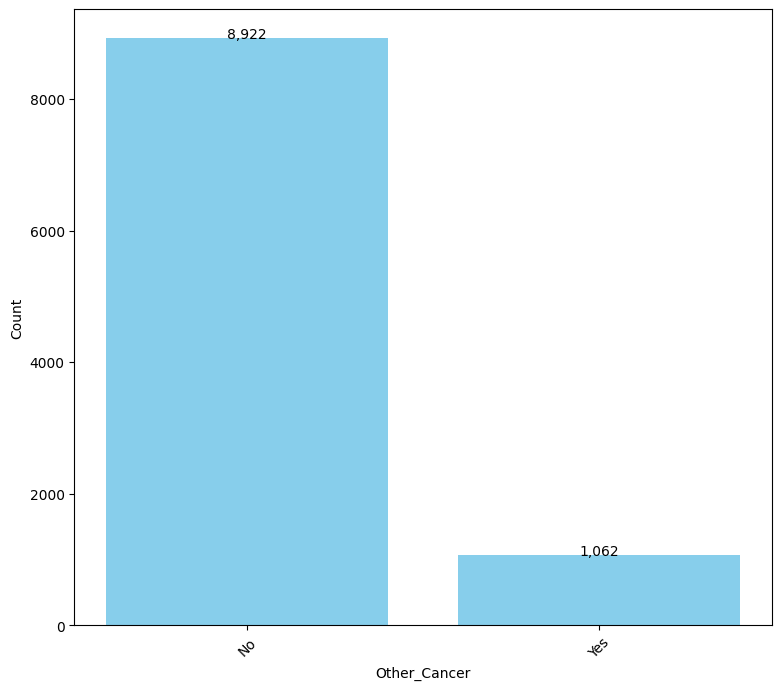

Depression


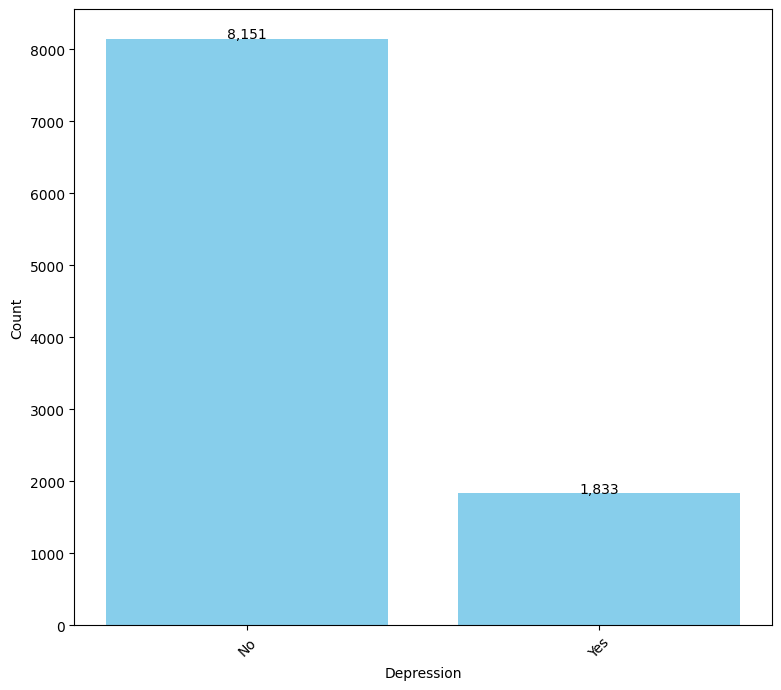

Diabetes


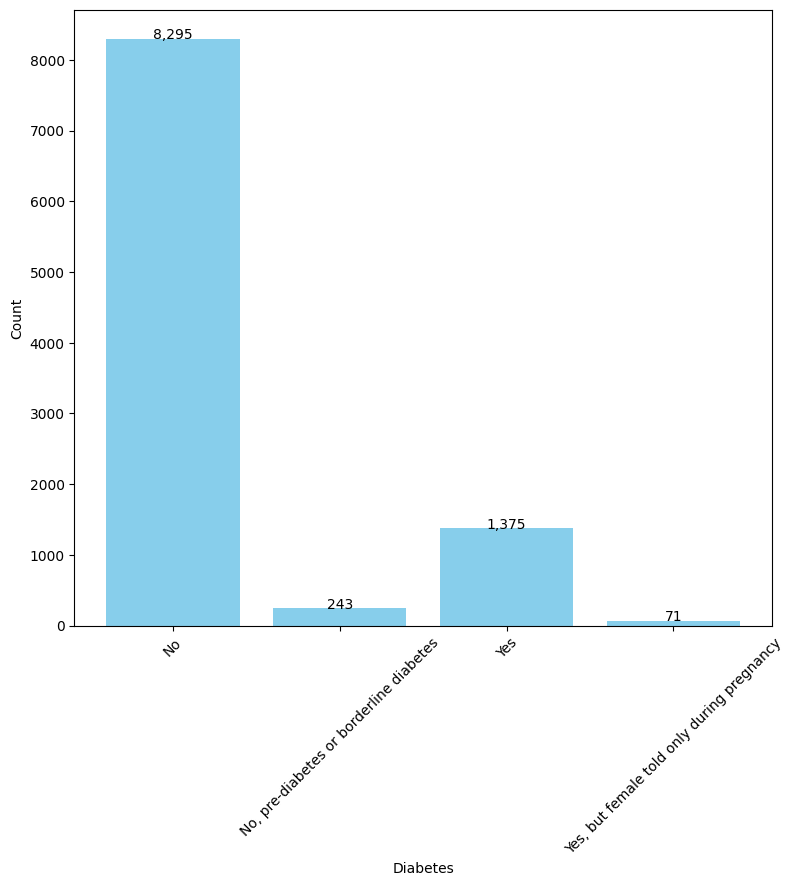

Arthritis


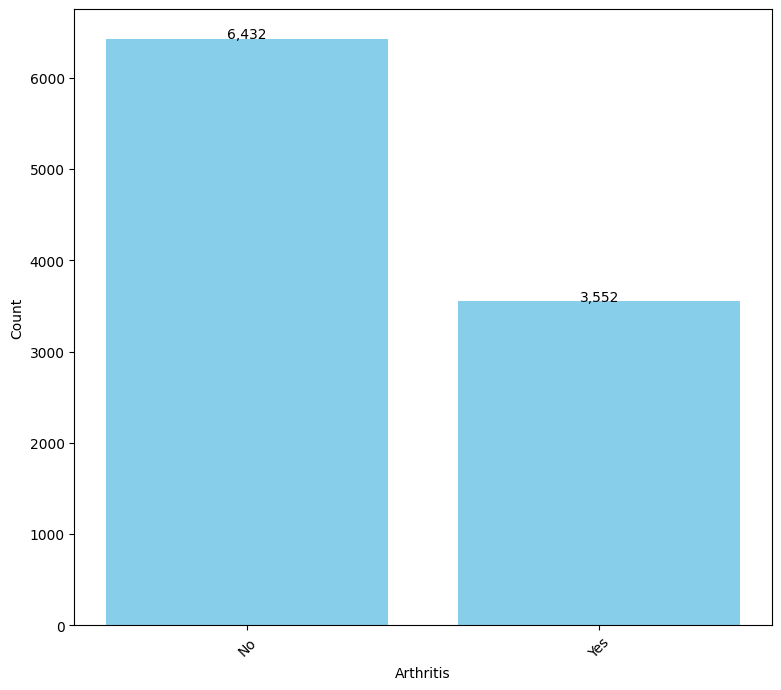

Sex


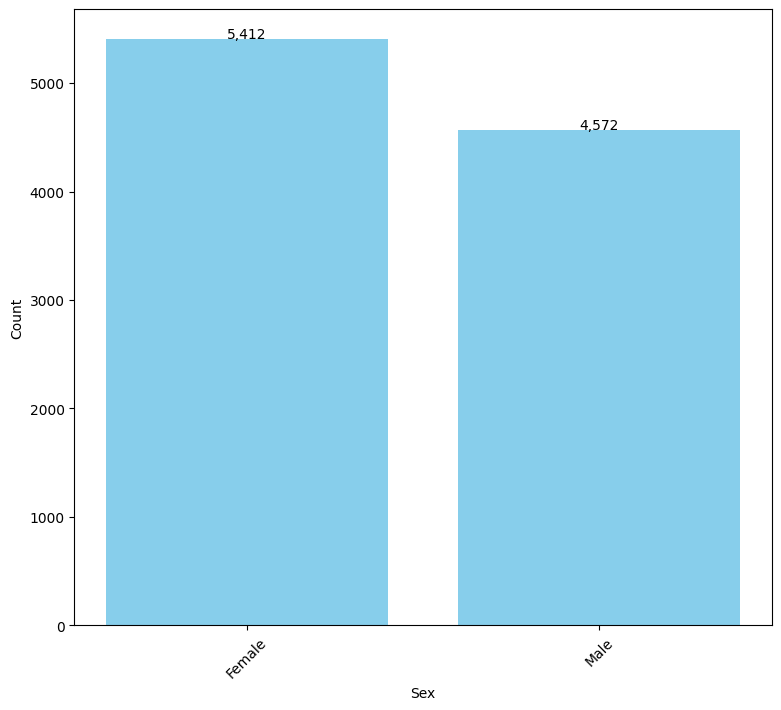

Age_Category


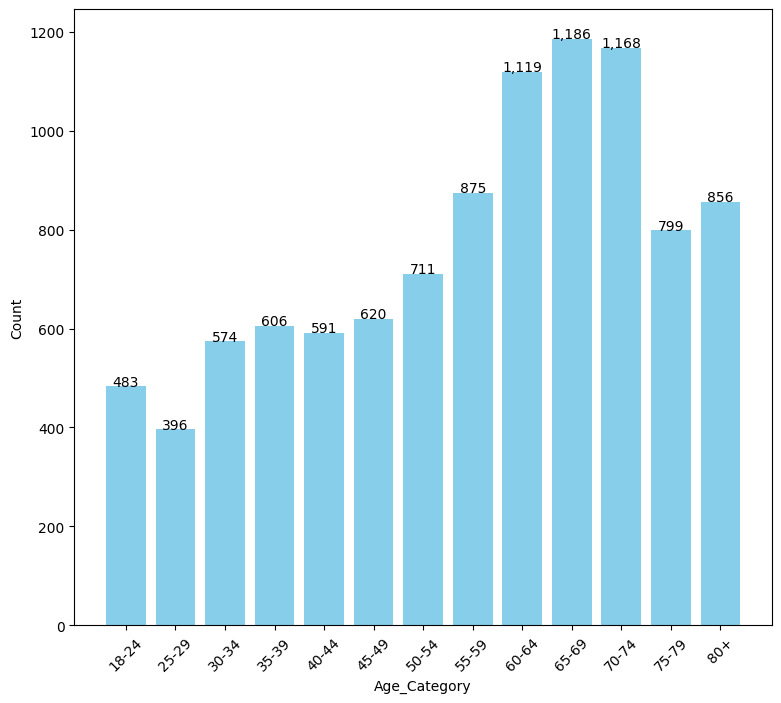

Height_(cm)


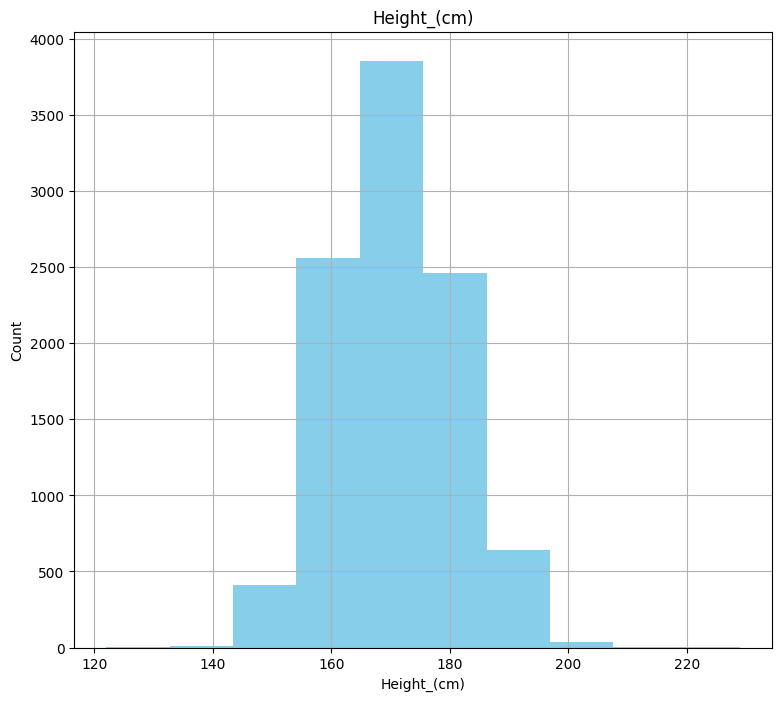

Weight_(kg)


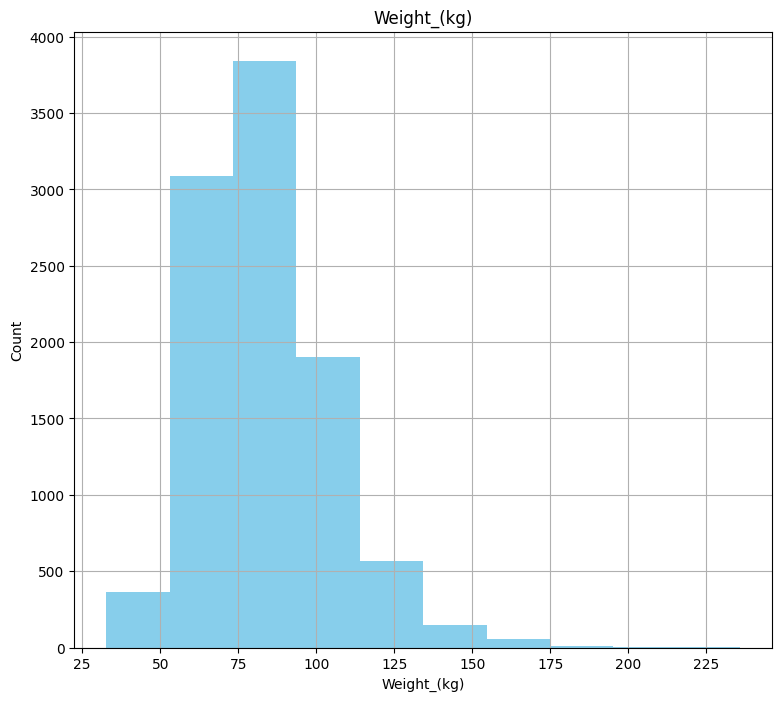

BMI


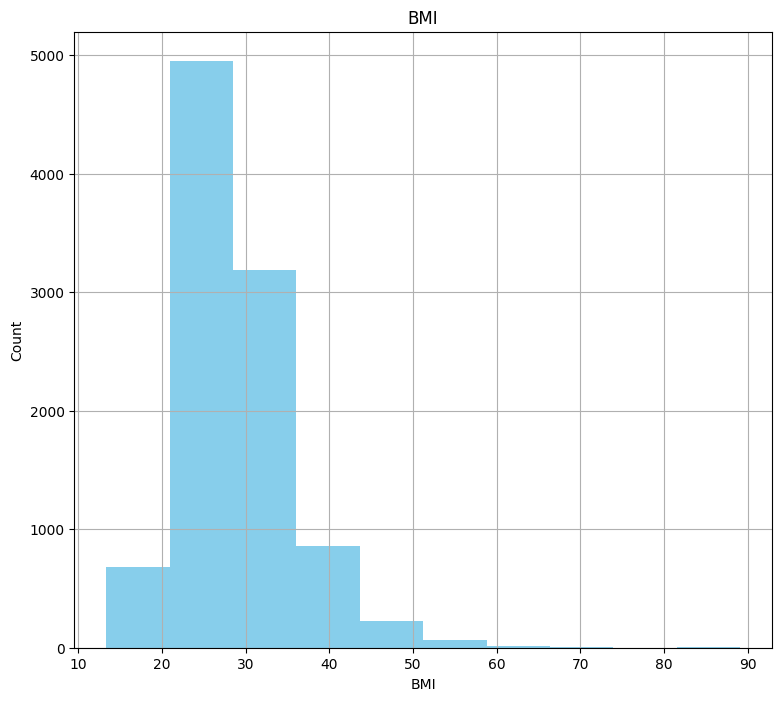

Smoking_History


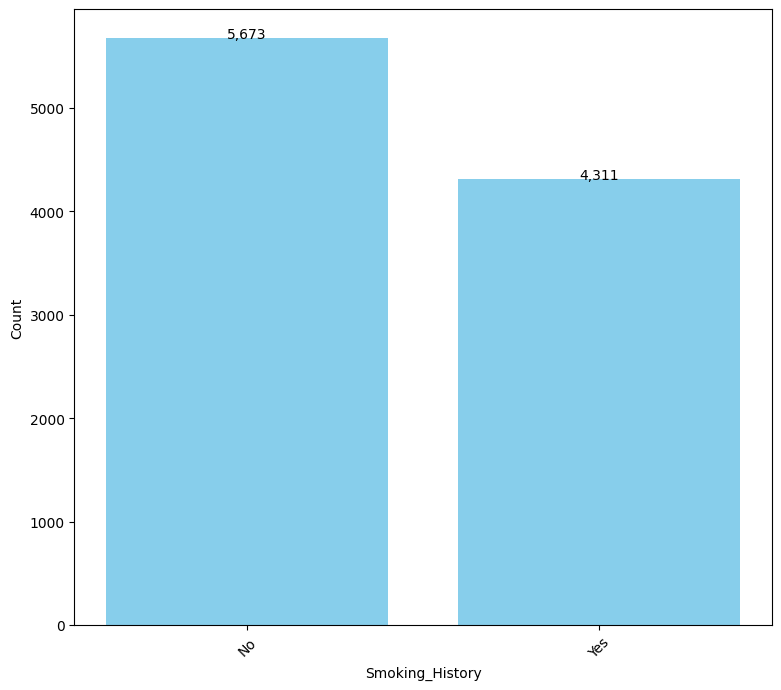

Alcohol_Consumption


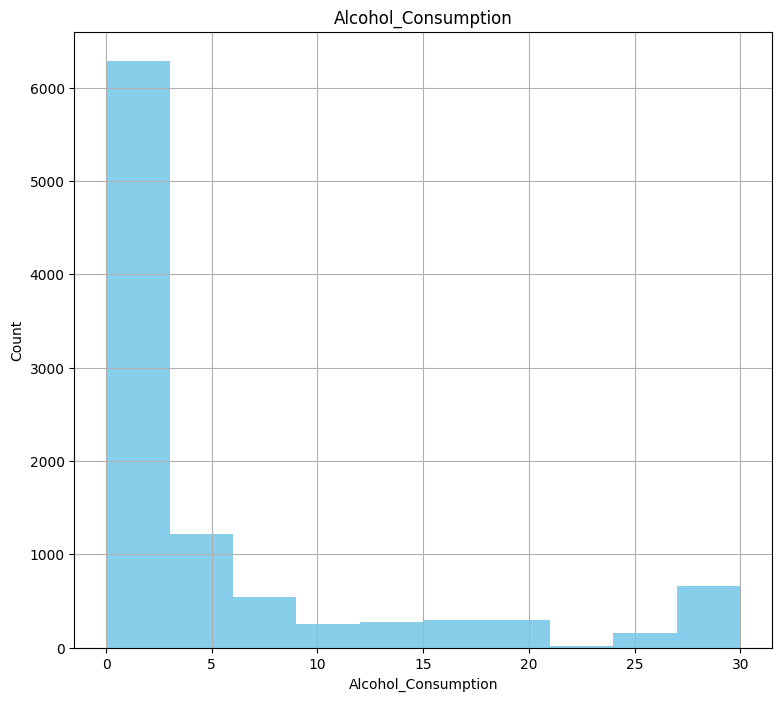

Fruit_Consumption


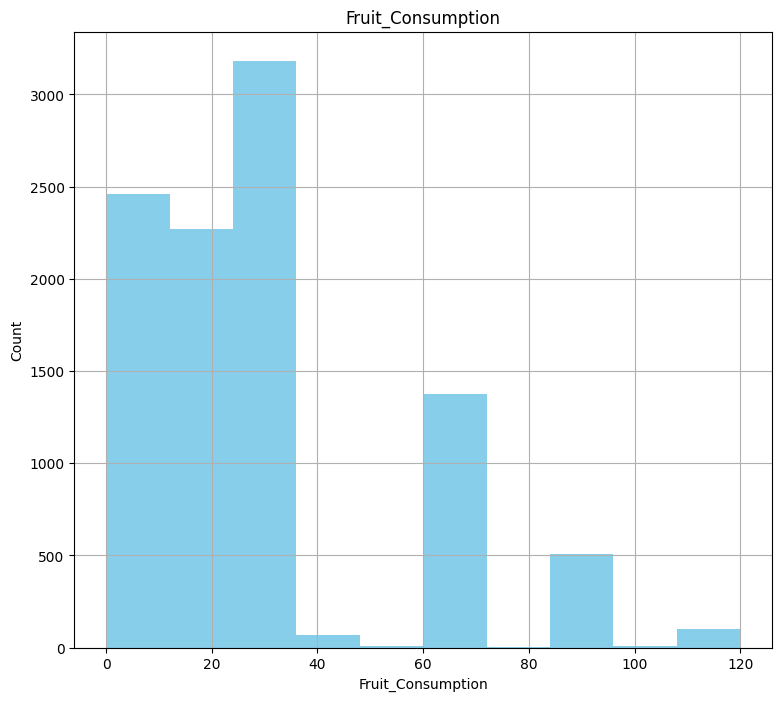

Green_Vegetables_Consumption


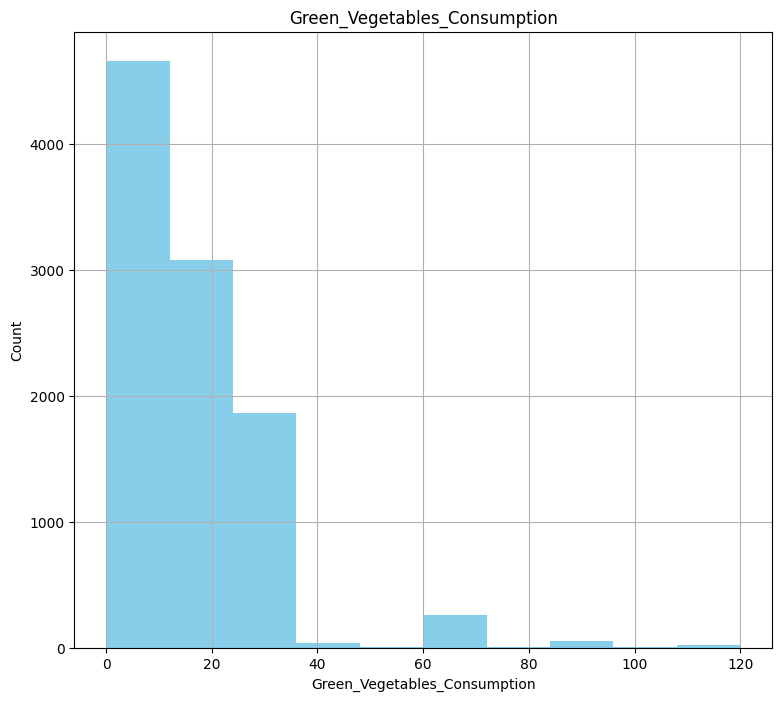

FriedPotato_Consumption


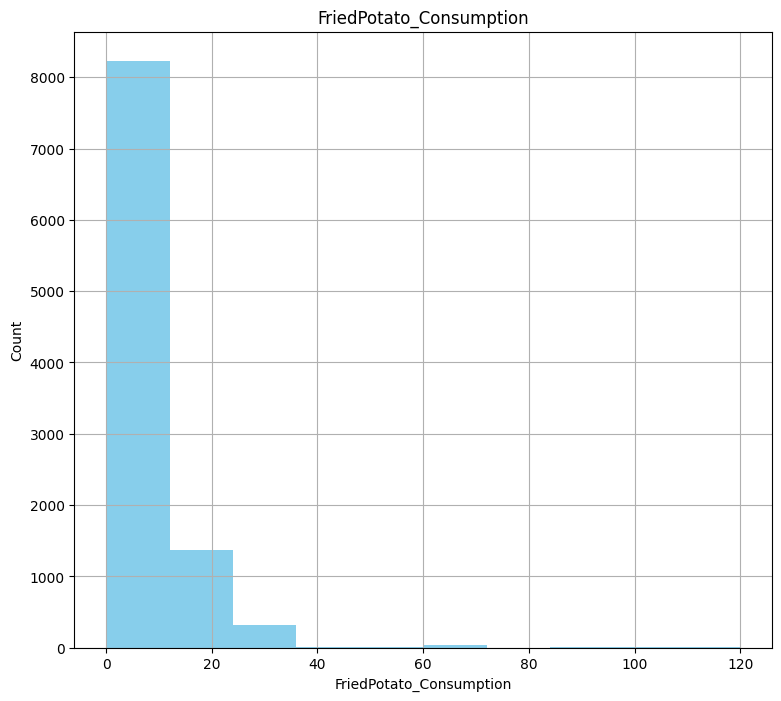

In [ ]:
import matplotlib.pyplot as plt

# Univariate Analysis
for i in df.columns:
    if i == target:
        continue

    if i in categorical_cols:
        if df.select(i).distinct().count() > 15:
            print(f'Column {i} has many unique values n = {df.select(i).distinct().count()} and will not be plotted')
            print('=======================================================')
            continue
        else:
            print(f'{i}')
            # Calculate counts for each category
            cat_counts = df.groupBy(i).count().orderBy(i).toPandas()

            # Plot countplot
            plt.figure(figsize=(9, 8))
            plt.bar(cat_counts[i], cat_counts['count'], color='skyblue')

            # Add count labels on top of the bars
            for j, count in enumerate(cat_counts['count']):
                plt.text(j, count + 0.5, f'{count:,}', ha='center')

            plt.xlabel(i)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.show()
            print('=======================================================')

    elif i in numerical_cols:
        print(f'{i}')
        # Plot histogram
        df.select(i).toPandas().hist(figsize=(9, 8), color='skyblue')
        plt.xlabel(i)
        plt.ylabel('Count')
        plt.show()
        print('=======================================================')


# Bivariate Analysis for Classification¶
# Categorical

Age_Category vs. Heart_Disease


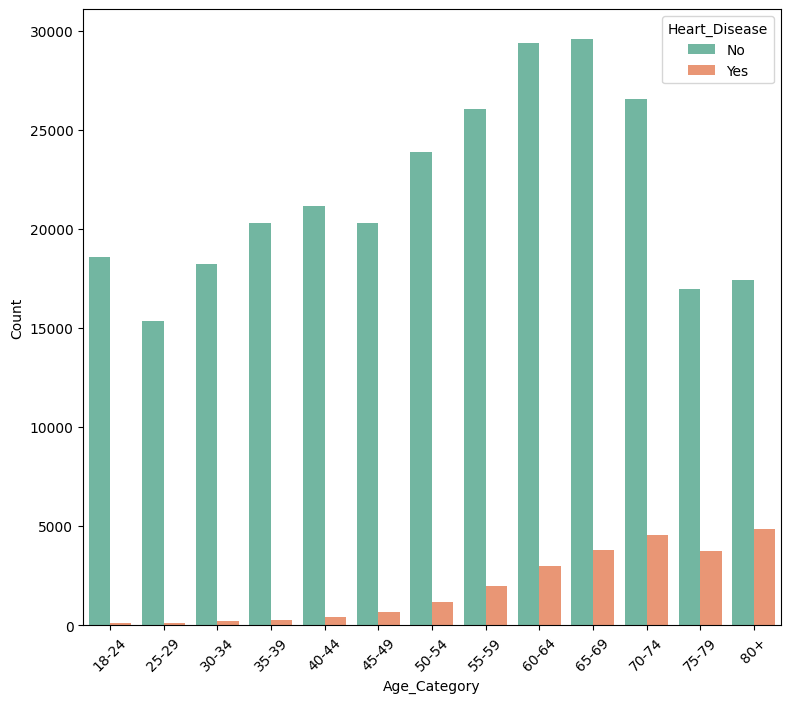

Arthritis vs. Heart_Disease


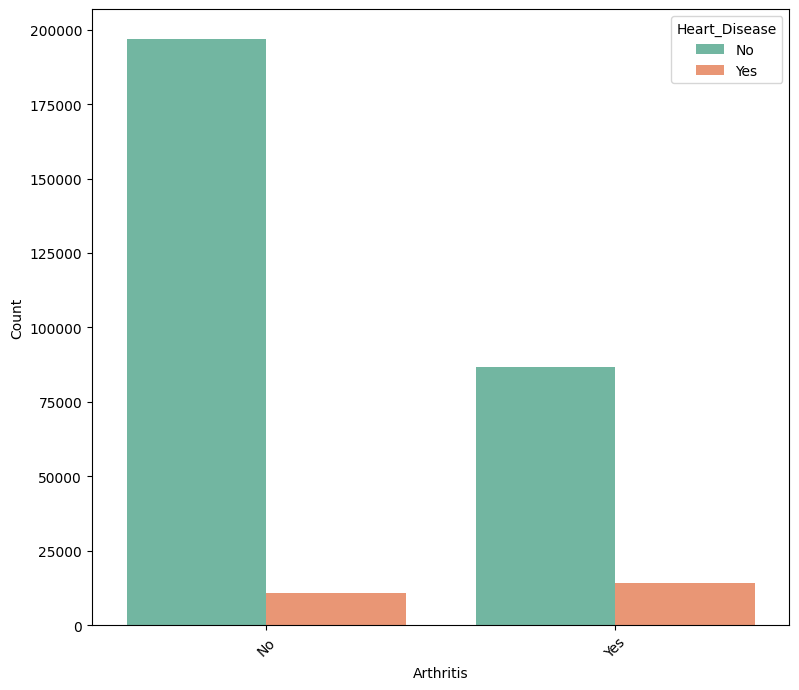

Checkup vs. Heart_Disease


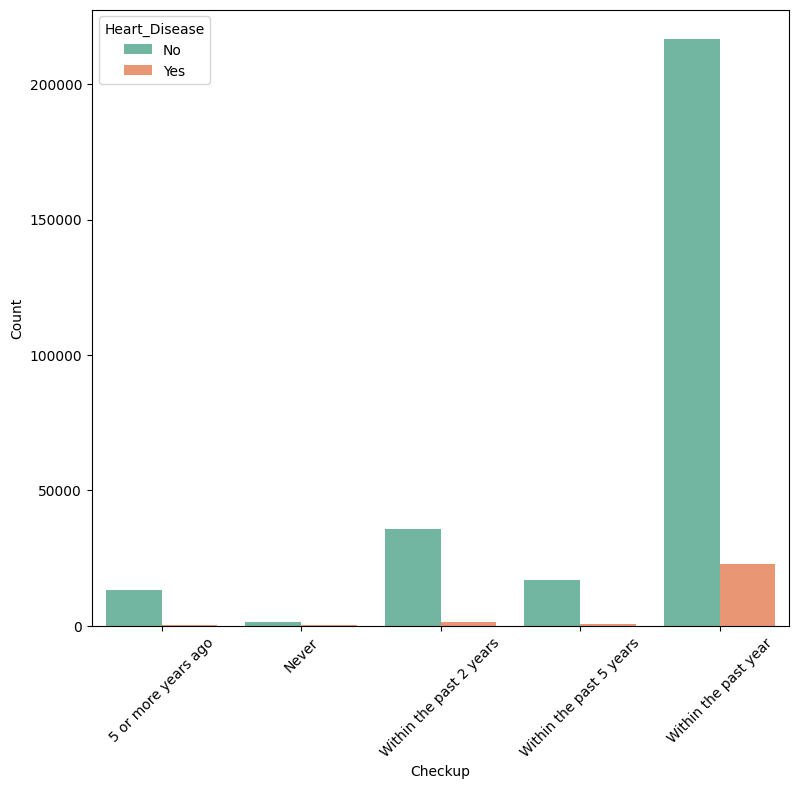

Depression vs. Heart_Disease


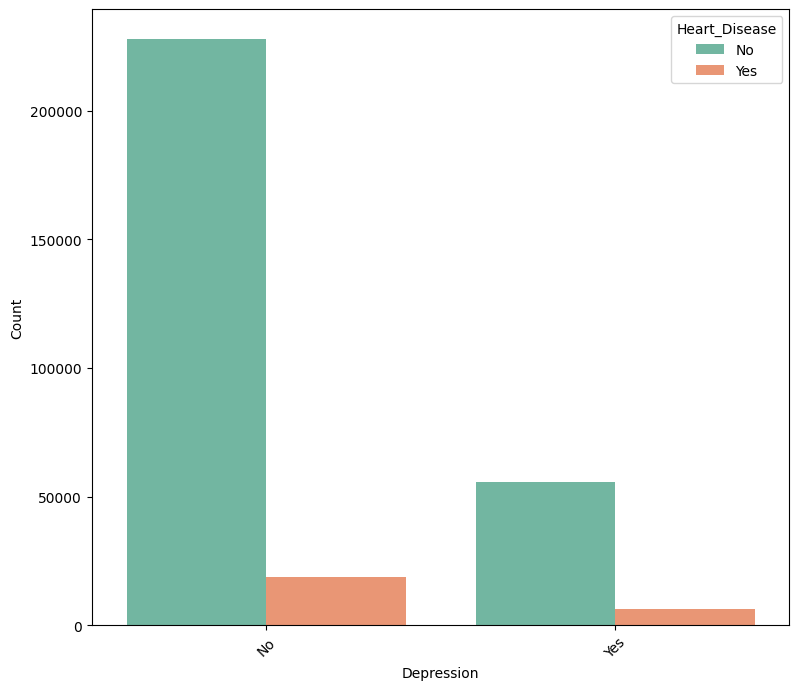

Diabetes vs. Heart_Disease


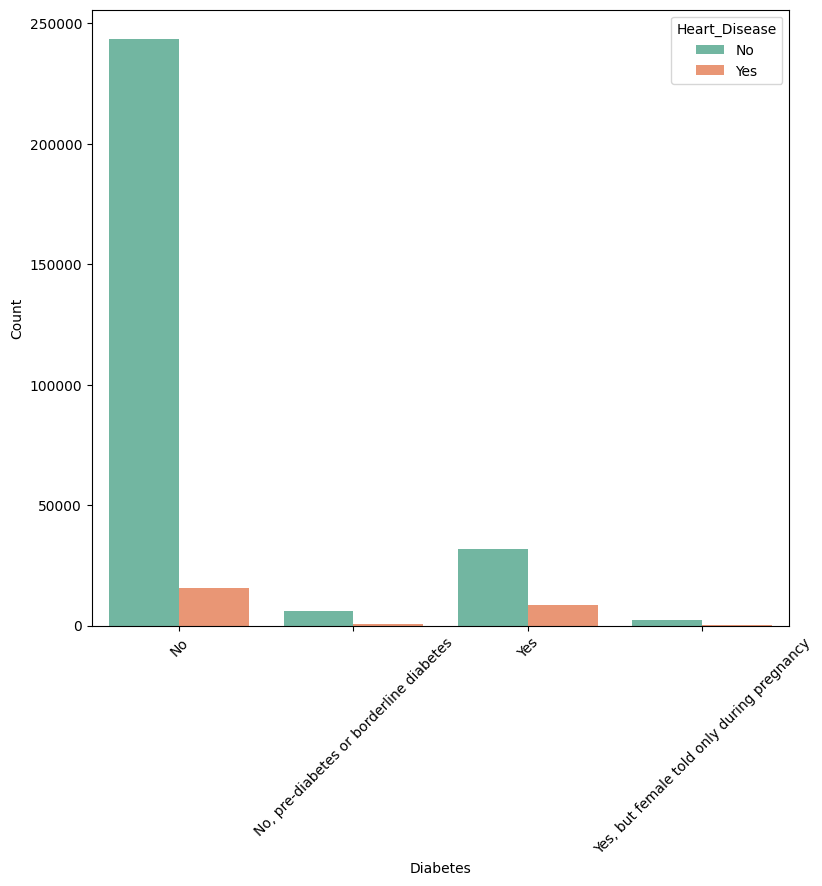

Exercise vs. Heart_Disease


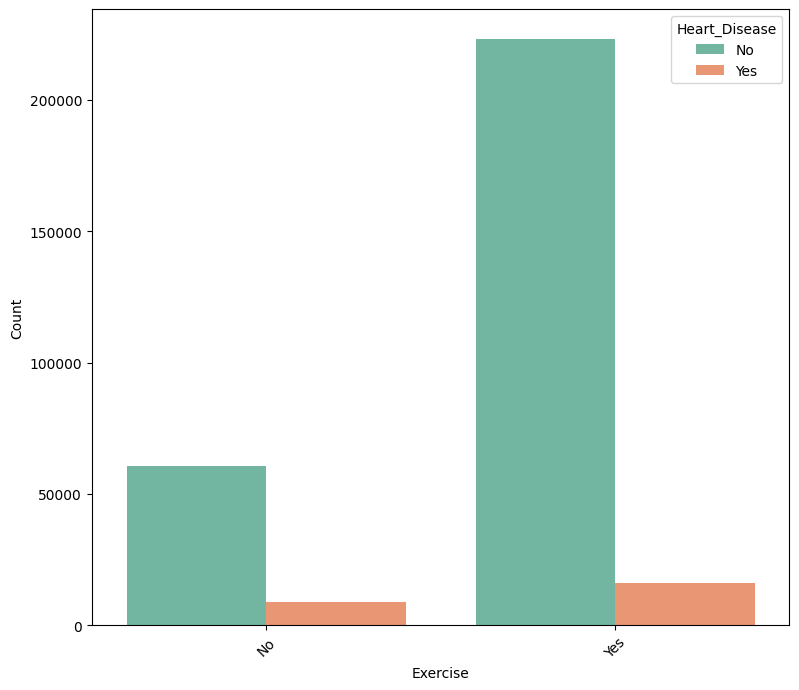

General_Health vs. Heart_Disease


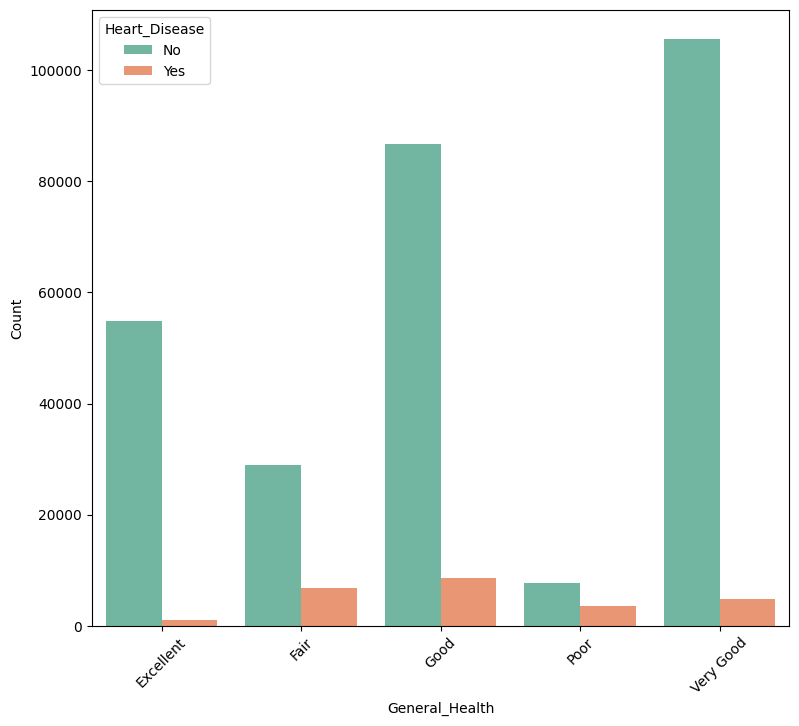

Other_Cancer vs. Heart_Disease


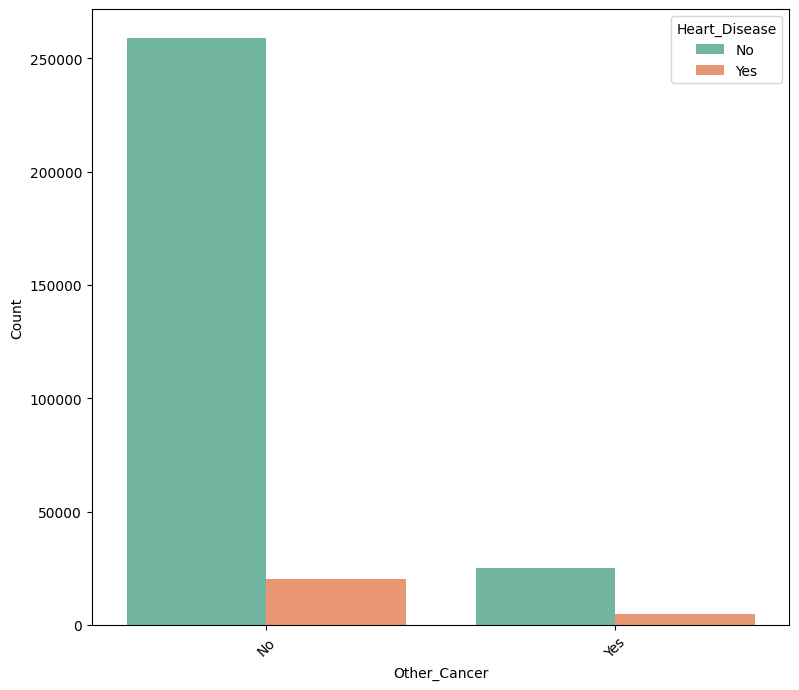

Sex vs. Heart_Disease


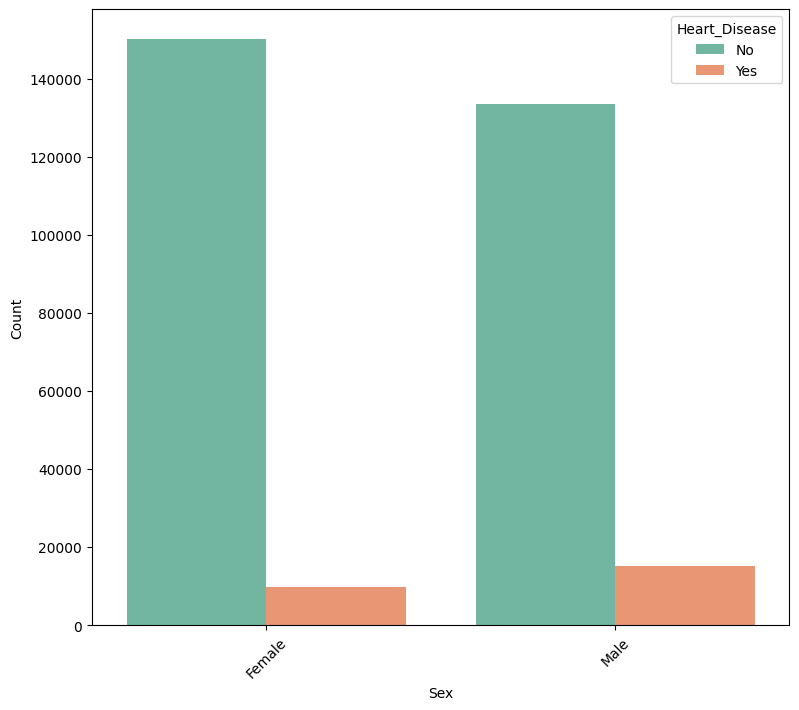

Skin_Cancer vs. Heart_Disease


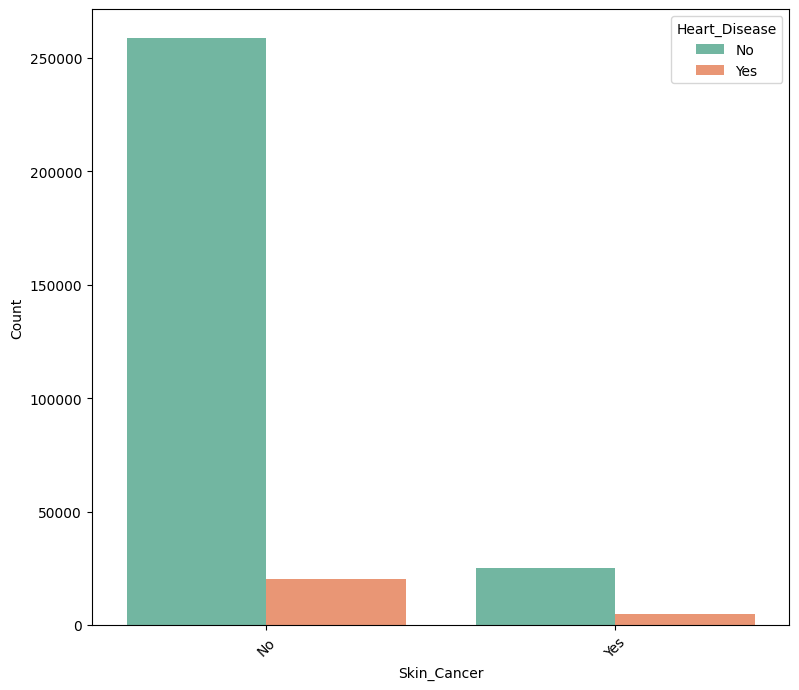

Smoking_History vs. Heart_Disease


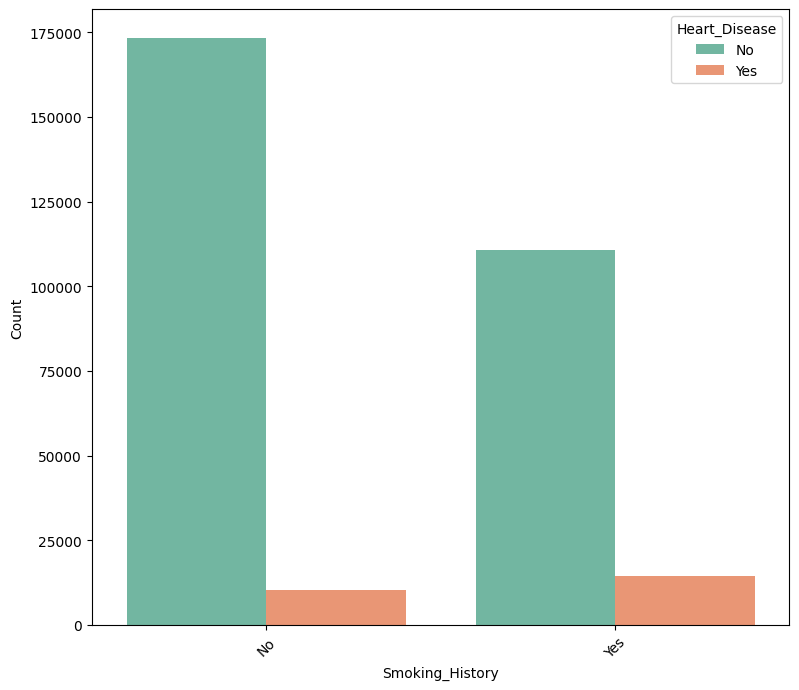

In [ ]:
import seaborn as sns

def eda_bivariate_categorical(df, column, target):
    """Function to perform bivariate analysis between a categorical column and the target variable."""
    # Calculate counts for each category
    cat_counts = df.groupBy(column, target).count().orderBy(column, target).toPandas()

    # Plot countplot
    plt.figure(figsize=(9, 8))
    sns.barplot(x=column, y='count', hue=target, data=cat_counts, palette='Set2')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=target)
    plt.show()

# Bivariate Analysis
for i in categorical_cols:
    if i == target:
        continue

    if df.select(i).distinct().count() > 15:
        print(f'Column {i} has many unique values n = {df.select(i).distinct().count()} and will not be plotted')
        print('=======================================================')
        continue

    print(f'{i} vs. {target}')
    eda_bivariate_categorical(df, i, target)
    print('=======================================================')


# Multivariate Analysis

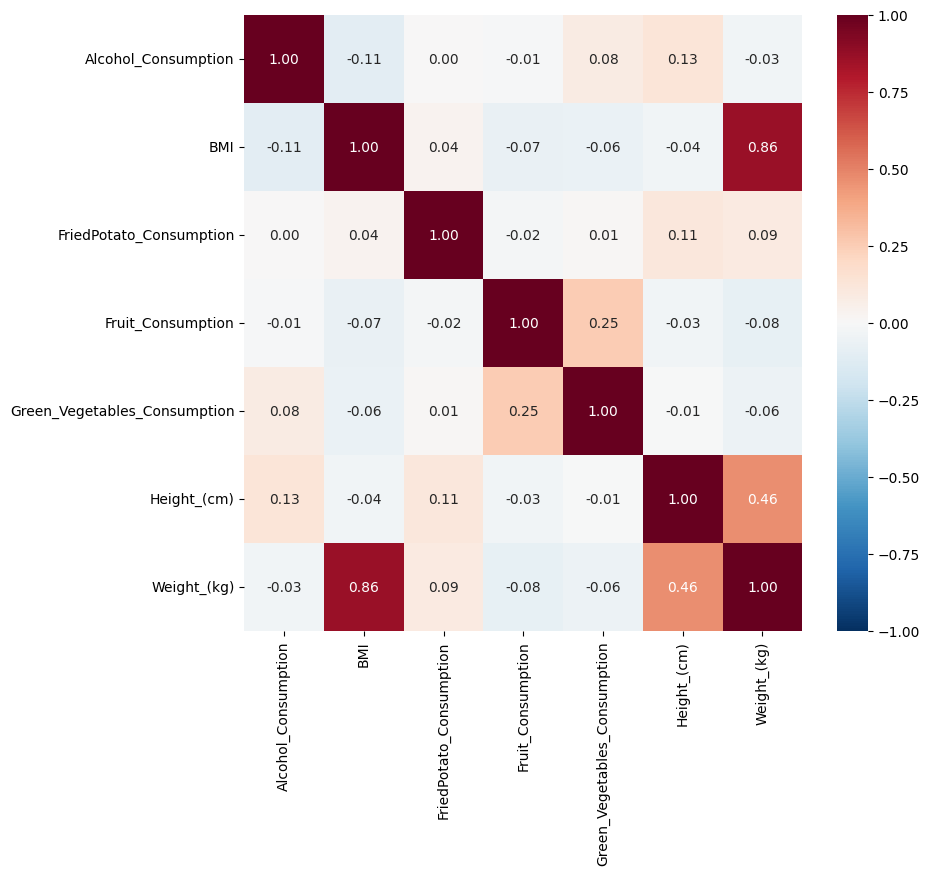

In [ ]:
import numpy as np
import seaborn as sns

# Collecting correlation matrix to the driver node
correlation_matrix = df.select(numerical_cols).toPandas().corr()

# Plotting the correlation matrix
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            vmin=-1, vmax=1)
plt.show()


# Preprocessing

# Changing the values of Heart Disease to 0 and 1 for preprocessing steps

In [ ]:
from pyspark.sql.functions import when

# Mapping 'No' to 0 and 'Yes' to 1
df = df.withColumn('Heart_Disease', when(df['Heart_Disease'] == 'No', 0).otherwise(1))

# Print value counts after mapping
print('')
print(df.groupBy('Heart_Disease').count().show())



+-------------+------+
|Heart_Disease| count|
+-------------+------+
|            1| 24971|
|            0|283883|
+-------------+------+

None


# Splitting the train and test set. Using stratify to keep the ratio between two classes be the same

In [ ]:
# Calculate the ratio of each class
ratio_no = df.filter(df['Heart_Disease'] == 0).count() / df.count()
ratio_yes = df.filter(df['Heart_Disease'] == 1).count() / df.count()

# Split the DataFrame using randomSplit
train_no, test_no = df.filter(df['Heart_Disease'] == 0).randomSplit([0.8 * ratio_no, 0.2 * ratio_no], seed=22)
train_yes, test_yes = df.filter(df['Heart_Disease'] == 1).randomSplit([0.8 * ratio_yes, 0.2 * ratio_yes], seed=22)

# Union the splits to get the final train and test DataFrames
train = train_no.union(train_yes)
test = test_no.union(test_yes)

# Print shapes of train and test DataFrames
print(train.count(), len(train.columns))
print(test.count(), len(test.columns))


246721 19
62133 19


In [ ]:
# Calculate the ratio of each class in the train set
train_yes_ratio = train.filter(train['Heart_Disease'] == 1).count() / train.count() * 100
train_no_ratio = train.filter(train['Heart_Disease'] == 0).count() / train.count() * 100

# Calculate the ratio of each class in the test set
test_yes_ratio = test.filter(test['Heart_Disease'] == 1).count() / test.count() * 100
test_no_ratio = test.filter(test['Heart_Disease'] == 0).count() / test.count() * 100

# Print the ratios
print('Train Set')
print(f'Ratio of people with heart disease to total is {train_yes_ratio:.2f}%')
print(f'Ratio of people that do not have heart disease to total is {train_no_ratio:.2f}%')
print('')

print('Test Set')
print(f'Ratio of people with heart disease to total is {test_yes_ratio:.2f}%')
print(f'Ratio of people that do not have heart disease to total is {test_no_ratio:.2f}%')


Train Set
Ratio of people with heart disease to total is 8.10%
Ratio of people that do not have heart disease to total is 91.90%

Test Set
Ratio of people with heart disease to total is 8.03%
Ratio of people that do not have heart disease to total is 91.97%


# Creating Pipelines¶
# Categorical Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder

# Define stages for the categorical pipeline
categorical_stages = []

# Iterate through categorical columns and create OneHotEncoder for each column
for col_name in categorical_cols:
    encoder = OneHotEncoder(inputCol=f"{col_name}_index", outputCol=f"{col_name}_encoded")
    categorical_stages.append(encoder)

# Create the categorical pipeline
cat_pipeline = Pipeline(stages=categorical_stages)


# Numerical Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# Define stages for the numerical pipeline
numerical_stages = []

# Iterate through numerical columns and create VectorAssembler for each column
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
numerical_stages.append(assembler)
# Apply StandardScaler to scaled numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
numerical_stages.append(scaler)

# Create the numerical pipeline
num_pipeline = Pipeline(stages=numerical_stages)


# Ordinal Pipelines

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes

# Define preprocessing pipelines
categorical_columns = ['Arthritis', 'Depression', 'Diabetes', 'Exercise', 'Other_Cancer', 'Sex', 'Skin_Cancer', 'Smoking_History']
ordinal_columns = ['Age_Category', 'Checkup', 'General_Health']
numerical_columns = ['BMI', 'Height_(cm)', 'Weight_(kg)', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

# Define StringIndexer and OneHotEncoder for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_columns]

# Define StringIndexer for ordinal columns
ordinal_indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in ordinal_columns]

# Define VectorAssembler for numerical columns
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

# Define StandardScaler for numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")

# Combine all stages for preprocessing
preprocessing_stages = indexers + encoders + ordinal_indexers + [assembler, scaler]

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=preprocessing_stages)

In [ ]:
# Transform the data
df_transformed = pipeline_model.transform(df)

# Show the first few rows of the transformed DataFrame
df_transformed.show(5)

# Print the schema of the transformed DataFrame
df_transformed.printSchema()

# Get the number of rows and columns
num_rows = df_transformed.count()
num_columns = len(df_transformed.columns)

print(f"Shape of the transformed DataFrame: ({num_rows}, {num_columns})")


+---+-------------------+-----------------+----------------------------+-----------------------+-----------+-----------+---------+----------+--------+--------+------------+------+-----------+---------------+------------+--------------+--------------------+---------------+----------------+--------------+--------------+------------------+---------+-----------------+---------------------+-----------------+------------------+----------------+----------------+--------------------+-------------+-------------------+-----------------------+------------------+-------------+--------------------+--------------------+-------------------------+
|BMI|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|Height_(cm)|Weight_(kg)|Arthritis|Depression|Diabetes|Exercise|Other_Cancer|   Sex|Skin_Cancer|Smoking_History|Age_Category|General_Health|             Checkup|Arthritis_index|Depression_index|Diabetes_index|Exercise_index|Other_Cancer_index|Sex_index|Skin_Cancer_

# Model


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import when, col
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("CardiovascularDiseasePrediction").getOrCreate()

# Load data
df = spark.read.csv('/content/CVD_cleaned.csv', header=True, inferSchema=True)

# Preprocessing
df = df.withColumn('Heart_Disease', when(df['Heart_Disease'] == 'No', 0).otherwise(1))

# Define feature columns
categorical_cols = ['Arthritis', 'Depression', 'Diabetes', 'Exercise', 'Other_Cancer', 'Sex', 'Skin_Cancer', 'Smoking_History', 'Age_Category', 'Checkup', 'General_Health']
numerical_cols = ['BMI', 'Height_(cm)', 'Weight_(kg)', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols]

# Assemble features
assembler_inputs = [col + "_encoded" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Define preprocessing pipeline
preprocessing_stages = indexers + encoders + [assembler]
preprocessing_pipeline = Pipeline(stages=preprocessing_stages)
pipeline_model = preprocessing_pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# Split data
train, test = df_transformed.randomSplit([0.8, 0.2], seed=22)

# Define models
models = {
    'Logistic_Regression': LogisticRegression(featuresCol='features', labelCol='Heart_Disease', maxIter=10000),
    'Decision_Tree': DecisionTreeClassifier(featuresCol='features', labelCol='Heart_Disease'),
    'Random_Forest': RandomForestClassifier(featuresCol='features', labelCol='Heart_Disease', numTrees=100),
    'GBT_Classifier': GBTClassifier(featuresCol='features', labelCol='Heart_Disease'),
    'Naive_Bayes': NaiveBayes(featuresCol='features', labelCol='Heart_Disease')
}

# Initialize evaluators
evaluator_roc = BinaryClassificationEvaluator(labelCol='Heart_Disease', metricName='areaUnderROC')
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol='Heart_Disease')

# Train and evaluate models
scores_dict = {}
report_dict = {}

for model_name, model in models.items():
    print(f'Training {model_name}...')

    # Fit model
    trained_model = model.fit(train)

    # Evaluate model
    roc_auc = evaluator_roc.evaluate(trained_model.transform(test))
    accuracy = evaluator_multiclass.evaluate(trained_model.transform(test), {evaluator_multiclass.metricName: "accuracy"})
    precision = evaluator_multiclass.evaluate(trained_model.transform(test), {evaluator_multiclass.metricName: "weightedPrecision"})
    recall = evaluator_multiclass.evaluate(trained_model.transform(test), {evaluator_multiclass.metricName: "weightedRecall"})
    f1 = evaluator_multiclass.evaluate(trained_model.transform(test), {evaluator_multiclass.metricName: "f1"})

    scores_dict[model_name] = {'ROC AUC': roc_auc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
    print('------------------------------------------------------------')
    print(f'The ROC AUC score for {model_name} is {roc_auc}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')
    print('------------------------------------------------------------')
